In [101]:
# Initializing Environment and Resources
import simpy
import numpy as np
import pandas as pd
env = simpy.Environment()
truck = simpy.Resource(env, capacity=1)
crane = simpy.Resource(env, capacity=1)

In [102]:
NUM_DAYS = 30
AVG_DAILY_FEU = 91
STD_DEV_FEU = 15
TRUCK_ROUND_TRIP_TIME = 2.0 #hours
CRANE_HANDLING_TIME = 0.5 #hour
NUM_TRUCKS = 9
NUM_CRANES = 3

In [103]:
# Data collectors
daily_requested = []
daily_processed = []
daily_queue_lengths = []

In [104]:
def container_process(env, name, trucks, cranes, queue_length):
    with trucks.request() as req_truck:
        yield req_truck
        yield env.timeout(TRUCK_ROUND_TRIP_TIME)

    with cranes.request() as req_crane:
        yield req_crane
        yield env.timeout(CRANE_HANDLING_TIME)

    queue_length[0] -= 1

In [105]:

def daily_dispatch(env, trucks, cranes):
    queue_length = [0]
    for day in range(NUM_DAYS):
        daily_FEUs = max(0, int(np.random.normal(AVG_DAILY_FEU, STD_DEV_FEU)))
        daily_requested.append(daily_FEUs)
        queue_length[0] += daily_FEUs

        for i in range(daily_FEUs):
            env.process(container_process(env, f'Day{day+1}_C{i+1}', trucks, cranes, queue_length))

        daily_queue_lengths.append(queue_length[0])

        yield env.timeout(24)

        processed = daily_requested[-1] - queue_length[0]
        daily_processed.append(processed)

In [106]:
# Create fresh environment
env = simpy.Environment()
trucks = simpy.Resource(env, capacity=NUM_TRUCKS)
cranes = simpy.Resource(env, capacity=NUM_CRANES)

env.process(daily_dispatch(env, trucks, cranes))
env.run(until=NUM_DAYS * 24)

# Make sure all arrays have the same length by truncating or padding
min_length = min(len(daily_requested), len(daily_processed), len(daily_queue_lengths), NUM_DAYS)

df_results = pd.DataFrame({
    'Day': range(1, min_length + 1),
    'Requested FEUs': daily_requested[:min_length],
    'Processed FEUs': daily_processed[:min_length],
    'Buffer Queue Length': daily_queue_lengths[:min_length]
})

print(df_results)

    Day  Requested FEUs  Processed FEUs  Buffer Queue Length
0     1              90              90                   90
1     2              68              68                   68
2     3              80              80                   80
3     4              71              71                   71
4     5              98              98                   98
5     6              80              80                   80
6     7              91              91                   91
7     8              87              87                   87
8     9              80              80                   80
9    10              99              99                   99
10   11              92              92                   92
11   12              77              77                   77
12   13             110              99                  110
13   14             114              97                  125
14   15              99              91                  116
15   16              91 

In [107]:
import matplotlib.pyplot as plt

In [108]:
days = df_results['Day'] + 1

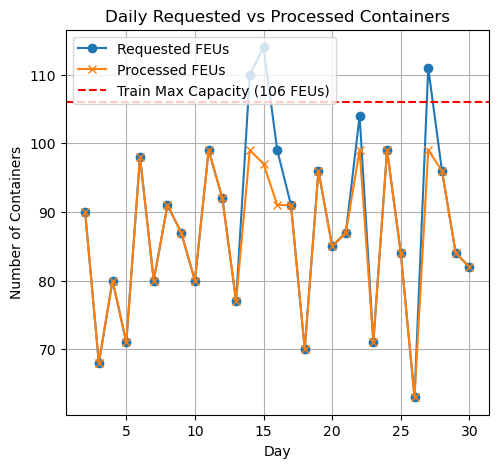

In [109]:
plt.figure(figsize=(12, 5))

# Plot 1: Requested vs Processed FEUs
plt.subplot(1, 2, 1)
plt.plot(days, df_results['Requested FEUs'], label='Requested FEUs', marker='o')
plt.plot(days, df_results['Processed FEUs'], label='Processed FEUs', marker='x')
plt.axhline(y=106, color='r', linestyle='--', label='Train Max Capacity (106 FEUs)')
plt.title('Daily Requested vs Processed Containers')
plt.xlabel('Day')
plt.ylabel('Number of Containers')
plt.legend()
plt.grid(True)

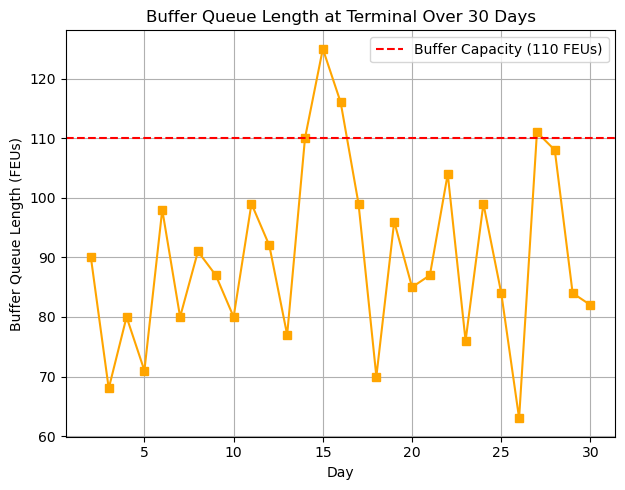

In [110]:
# Plot 2: Buffer Queue Length Over Time
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(days, df_results['Buffer Queue Length'], color='orange', marker='s')
plt.axhline(y=110, color='r', linestyle='--', label='Buffer Capacity (110 FEUs)')
plt.title('Buffer Queue Length at Terminal Over 30 Days')
plt.xlabel('Day')
plt.ylabel('Buffer Queue Length (FEUs)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()